In [ ]:
pip install open3d numpy scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded point cloud with 3056 points.
Plane 0: 2592 inliers, normal = (0.14, -0.01, 0.99)
Plane 1: 418 inliers, normal = (0.14, 0.97, -0.19)


<ipython-input-4-f42c735da6c6>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(planes))


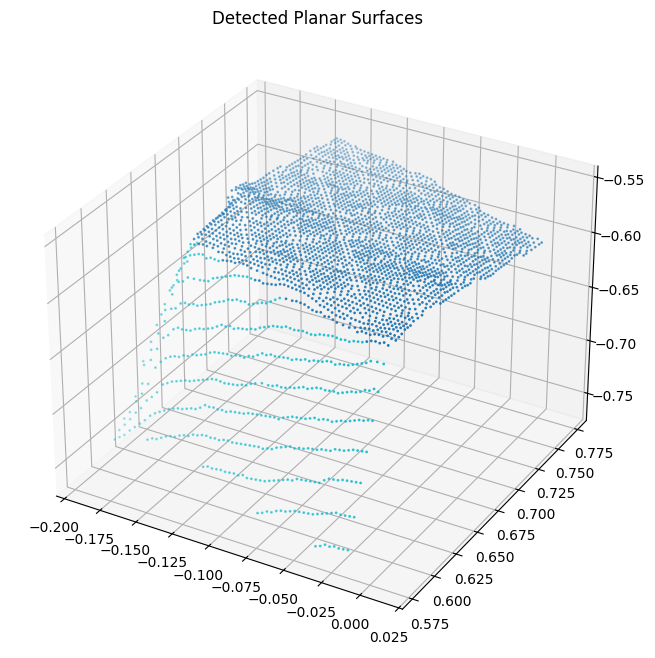

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_point_cloud(file_path):
    pcd = o3d.io.read_point_cloud(file_path)
    print(f"Loaded point cloud with {np.asarray(pcd.points).shape[0]} points.")
    return pcd

def detect_planes(pcd, distance_threshold=0.01, ransac_n=3, num_iterations=1000, min_points=100):
    planes = []
    colors = [
        [1, 0, 0], [0, 1, 0], [0, 0, 1],  # RGB
        [1, 1, 0], [0, 1, 1], [1, 0, 1],  # CMY
        [0.5, 0.5, 0.5], [1, 0.5, 0], [0.5, 0, 1]
    ]
    pcd_remaining = pcd
    i = 0

    while True:
        if len(pcd_remaining.points) < min_points:
            break

        plane_model, inliers = pcd_remaining.segment_plane(distance_threshold=distance_threshold,
                                                            ransac_n=ransac_n,
                                                            num_iterations=num_iterations)
        [a, b, c, d] = plane_model
        print(f"Plane {i}: {len(inliers)} inliers, normal = ({a:.2f}, {b:.2f}, {c:.2f})")

        inlier_cloud = pcd_remaining.select_by_index(inliers)
        inlier_cloud.paint_uniform_color(colors[i % len(colors)])
        planes.append((plane_model, inlier_cloud))

        # Remove inliers for next round
        pcd_remaining = pcd_remaining.select_by_index(inliers, invert=True)
        i += 1

    return planes

def plot_planes_matplotlib(planes):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = plt.cm.get_cmap("tab10", len(planes))

    for i, (plane_model, cloud) in enumerate(planes):  # ← Unpack here
        pts = np.asarray(cloud.points)
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=1, color=colors(i))

    ax.set_title("Detected Planar Surfaces")
    plt.show()

def get_plane_features(plane_model, cloud):
    points = np.asarray(cloud.points)
    centroid = points.mean(axis=0)
    normal = np.array(plane_model[:3])
    normal = normal / np.linalg.norm(normal)
    return centroid, normal

angle = np.arccos(np.clip(np.dot(normal1, normal2), -1.0, 1.0)) * 180 / np.pi

from sklearn.cluster import DBSCAN

def cluster_plane_centroids(centroids, eps=0.2, min_samples=3):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(centroids)
    return clustering.labels_

file_path = "/content/sample_data/small_box_0_raw.ply"  # Change this to your .ply path
pcd = load_point_cloud(file_path)
planes = detect_planes(pcd)
plot_planes_matplotlib(planes)

Processing: /content/sample_data/small_box_0_raw.ply
Processing: /content/sample_data/small_box_10_raw.ply
Processing: /content/sample_data/small_box_1_raw.ply
Processing: /content/sample_data/small_box_2_raw.ply
Processing: /content/sample_data/small_box_3_raw.ply
Processing: /content/sample_data/small_box_4_raw.ply
Processing: /content/sample_data/small_box_5_raw.ply
Processing: /content/sample_data/small_box_6_raw.ply
Processing: /content/sample_data/small_box_7_raw.ply
Processing: /content/sample_data/small_box_8_raw.ply
Processing: /content/sample_data/small_box_9_raw.ply
Processed 11 boxes.


<ipython-input-15-c7a1db04bab8>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(grouped_planes))


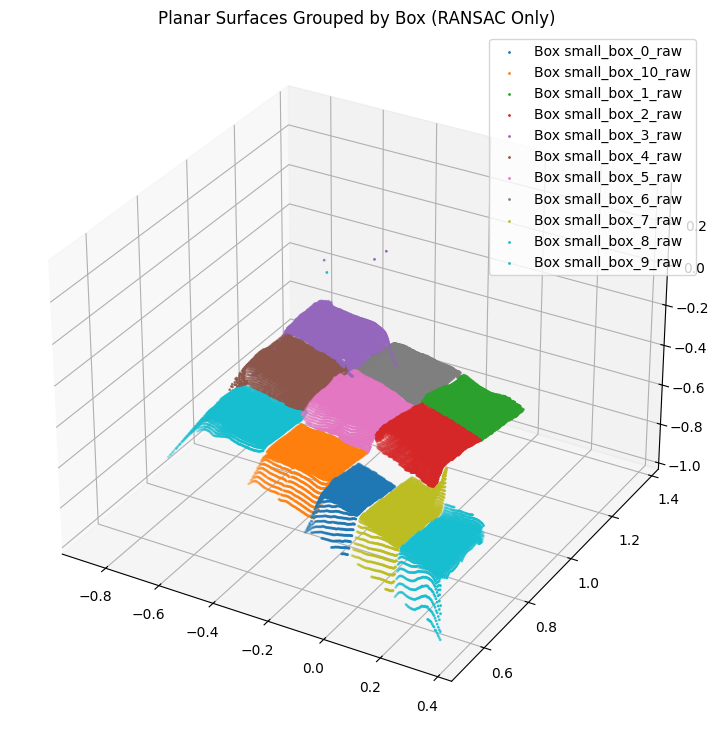

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

# --- Parameters ---
PLY_FOLDER = "/content/sample_data"   # Change this to your folder
DIST_THRESHOLD = 0.005
MIN_POINTS = 50

# --- RANSAC Plane Detection ---
def detect_planes(pcd, distance_threshold=DIST_THRESHOLD, ransac_n=3, num_iterations=1000, min_points=MIN_POINTS):
    planes = []
    remaining = pcd
    while True:
        if len(remaining.points) < min_points:
            break
        model, inliers = remaining.segment_plane(distance_threshold, ransac_n, num_iterations)
        cloud = remaining.select_by_index(inliers)
        planes.append((model, cloud))
        remaining = remaining.select_by_index(inliers, invert=True)
    return planes

# --- Visualization ---
def visualize_box_planes(grouped_planes):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    color_map = plt.cm.get_cmap("tab10", len(grouped_planes))

    for idx, (box_id, planes) in enumerate(grouped_planes.items()):
        for j, (model, cloud) in enumerate(planes):
            pts = np.asarray(cloud.points)
            if pts.ndim != 2 or pts.shape[1] != 3:
                continue  # skip malformed plane
            label = f"Box {box_id}" if j == 0 else None
            ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=1, color=color_map(idx), label=label)

    ax.set_title("Planar Surfaces Grouped by Box (RANSAC Only)")
    ax.legend()
    plt.show()

# --- Main ---
grouped_planes = {}
ply_files = sorted(glob(os.path.join(PLY_FOLDER, "*.ply")))

for i, ply_path in enumerate(ply_files):
    print(f"Processing: {ply_path}")
    box_id = os.path.splitext(os.path.basename(ply_path))[0]
    pcd = o3d.io.read_point_cloud(ply_path)
    planes = detect_planes(pcd)
    grouped_planes[box_id] = planes

print(f"Processed {len(grouped_planes)} boxes.")
visualize_box_planes(grouped_planes)